# 🎨 GAN-Based Image Colorization Project

## Overview
This project implements a **Generative Adversarial Network (GAN)** for automatic image colorization, transforming grayscale flower images into realistic colored versions. Using a **pix2pix architecture** with U-Net generator and PatchGAN discriminator, the model learns to predict natural colors from grayscale inputs.

## Key Features
- **U-Net Generator**: Encoder-decoder architecture with skip connections for detailed image reconstruction
- **PatchGAN Discriminator**: Focuses on local image patches for realistic texture generation  
- **Combined Loss Function**: GAN loss + L1 loss for both adversarial training and pixel-level accuracy
- **TensorFlow Flowers Dataset**: Training on diverse flower images for robust colorization

## Project Structure
1. **Data Preprocessing**: RGB to grayscale conversion and normalization
2. **Model Architecture**: Generator and discriminator network definitions
3. **Training Pipeline**: Adversarial training with loss monitoring
4. **Results Visualization**: Interactive exploration of colorization results

## Expected Outcomes
The trained model will demonstrate the ability to add realistic colors to grayscale flower images, showcasing the power of GANs for image-to-image translation tasks.

# 📚 Import Libraries and Setup Environment

In [56]:
# Install tensorflow if not already installed
!pip install -q tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from IPython.display import clear_output
import tensorflow_datasets as tfds


# 🖼️ Data Preprocessing and Dataset Loading

In [57]:
def rgb_to_grayscale(image):
    gray_image = tf.image.rgb_to_grayscale(image)
    gray_image = tf.image.grayscale_to_rgb(gray_image)  # Keep 3 channels for model compatibility
    return gray_image

def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image

def preprocess(image):
    image = tf.image.resize(image, [256, 256])
    input_image = rgb_to_grayscale(image)
    target_image = image
    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image

# Load the dataset
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

# Prepare dataset: shuffle, take 200 samples, batch size 4
train_ds = dataset['train'].map(lambda img, label: preprocess(img))
train_ds = train_ds.shuffle(1000).take(200).batch(4)

# Quick preview of input and target shapes
for input_img, target_img in train_ds.take(1):
    print("Input (grayscale) shape:", input_img.shape)
    print("Target (color) shape:", target_img.shape)


Input (grayscale) shape: (4, 256, 256, 3)
Target (color) shape: (4, 256, 256, 3)


# 🏗️ U-Net Generator Architecture

In [58]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                        # (bs, 64, 64, 128)
        downsample(256, 4),                        # (bs, 32, 32, 256)
        downsample(512, 4),                        # (bs, 16, 16, 512)
        downsample(512, 4),                        # (bs, 8, 8, 512)
        downsample(512, 4),                        # (bs, 4, 4, 512)
        downsample(512, 4),                        # (bs, 2, 2, 512)
        downsample(512, 4),                        # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),     # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),     # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),     # (bs, 8, 8, 1024)
        upsample(512, 4),                         # (bs, 16, 16, 1024)
        upsample(256, 4),                         # (bs, 32, 32, 512)
        upsample(128, 4),                         # (bs, 64, 64, 256)
        upsample(64, 4),                          # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_36       │ (None, 128, 128,  │      3,072 │ input_layer_38[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_37       │ (None, 64, 64,    │    131,584 │ sequential_36[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_38       │ (None, 32, 32,    │    525,312 │ sequential_37[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_39       │ (None, 16, 16,    │  2,099,200 │ sequential_38[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_40       │ (None, 8, 8, 512) │  4,196,352 │ sequential_39[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_41       │ (None, 4, 4, 512) │  4,196,352 │ sequential_40[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_42       │ (None, 2, 2, 512) │  4,196,352 │ sequential_41[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_43       │ (None, 1, 1, 512) │  4,196,352 │ sequential_42[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_44       │ (None, 2, 2, 512) │  4,196,352 │ sequential_43[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 2, 2,      │          0 │ sequential_44[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_42[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_45       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_16[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 4, 4,      │          0 │ sequential_45[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_41[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_46       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_17[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 8, 8,      │          0 │ sequential_46[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_40[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_47       │ (None, 16, 16,    │  8,390,656 │ concatenate_18[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 16, 16,    │          0 │ sequential_47[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

# 🔍 PatchGAN Discriminator Architecture


In [59]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # Condition on input image

    down1 = downsample(64, 4, apply_batchnorm=False)(x)   # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)                     # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)                     # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)             # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)       # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)        # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
discriminator.summary()


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_51       │ (None, 128, 128,  │      6,144 │ concatenate_23[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 64, 64,    │    131,584 │ sequential_51[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 32, 32,    │    525,312 │ sequential_52[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 34, 34,    │          0 │ sequential_53[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_4… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 33, 33,    │          0 │ leaky_re_lu_35[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

# ⚙️ Model Initialization

In [60]:
# Build models by running one batch through them before training
for example_input, example_target in train_ds.take(1):
    _ = generator(example_input)
    _ = discriminator([example_input, example_target])


# 📊 Loss Functions and Optimizers

In [61]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)  # L1 loss weighted by 100
    return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# 🔄 Training Step Function

In [75]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


# 🚀 Training Loop Execution

In [65]:
import time
EPOCHS = 30

def fit_with_plots(train_ds, EPOCHS):
    for epoch in range(EPOCHS):
        start = time.time()
        print(f"Starting epoch {epoch + 1}...")
        
        for step, (input_image, target) in enumerate(train_ds):
            gen_loss, disc_loss = train_step(input_image, target)
            if step % 50 == 0:
                print(f"  Step {step}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")
        
        print(f'Epoch {epoch + 1}/{EPOCHS} completed, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}, Time: {time.time() - start:.2f}s\n')

fit_with_plots(train_ds, EPOCHS)

Starting epoch 1...
  Step 0, Gen Loss: 17.7504, Disc Loss: 0.5905
Epoch 1/30 completed, Generator Loss: 26.0621, Discriminator Loss: 0.3659, Time: 13.85s

Starting epoch 2...
  Step 0, Gen Loss: 22.6637, Disc Loss: 0.3044
Epoch 2/30 completed, Generator Loss: 20.2400, Discriminator Loss: 1.0025, Time: 13.90s

Starting epoch 3...
  Step 0, Gen Loss: 17.5722, Disc Loss: 1.6271
Epoch 3/30 completed, Generator Loss: 18.8216, Discriminator Loss: 2.0059, Time: 12.88s

Starting epoch 4...
  Step 0, Gen Loss: 21.3216, Disc Loss: 0.4604
Epoch 4/30 completed, Generator Loss: 16.2246, Discriminator Loss: 0.6154, Time: 12.58s

Starting epoch 5...
  Step 0, Gen Loss: 16.1889, Disc Loss: 0.3850
Epoch 5/30 completed, Generator Loss: 17.3065, Discriminator Loss: 1.6900, Time: 12.50s

Starting epoch 6...
  Step 0, Gen Loss: 19.3467, Disc Loss: 0.9305
Epoch 6/30 completed, Generator Loss: 20.4453, Discriminator Loss: 0.3872, Time: 12.53s

Starting epoch 7...
  Step 0, Gen Loss: 18.4538, Disc Loss: 0.39

# 📸 Results Visualization Function

In [80]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5))  # scale from [-1,1] to [0,1]
        plt.axis('off')
    plt.show()


# 🎯 Generate Sample Results

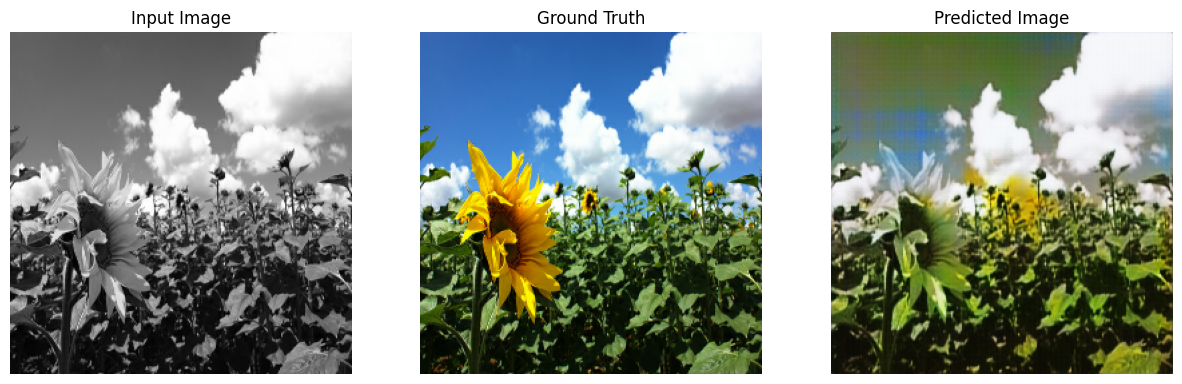

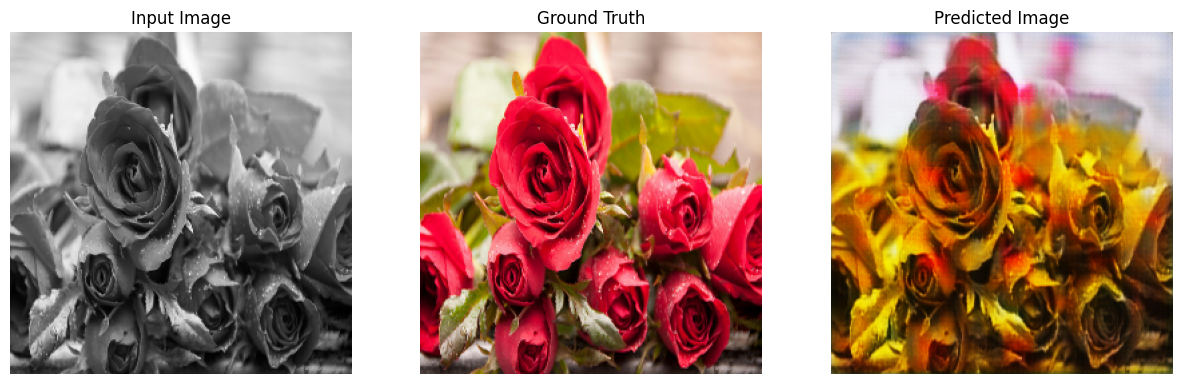

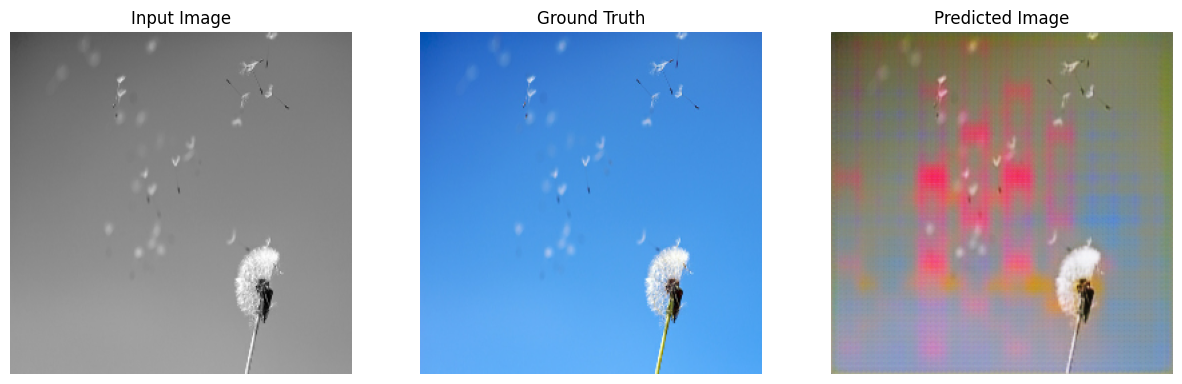

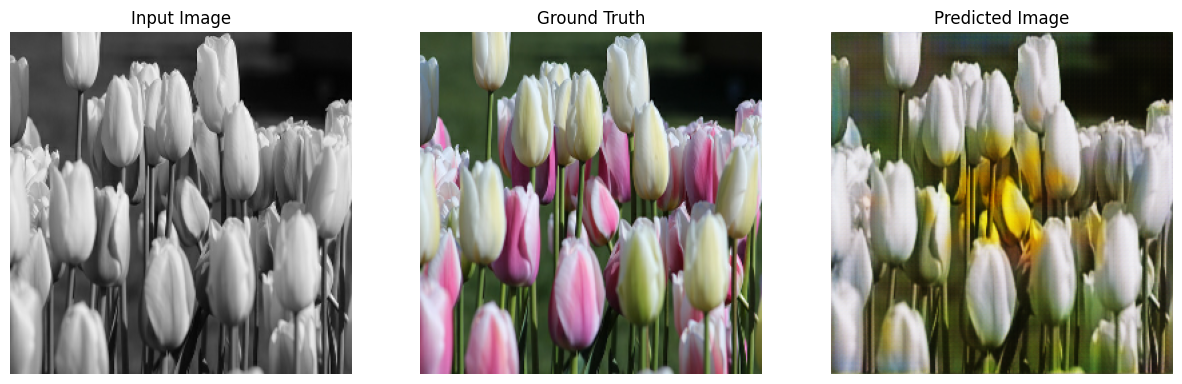

In [78]:
for example_input, example_target in train_ds.take(4):
    generate_images(generator, example_input, example_target) 

# 🔍 Interactive Results Explorer

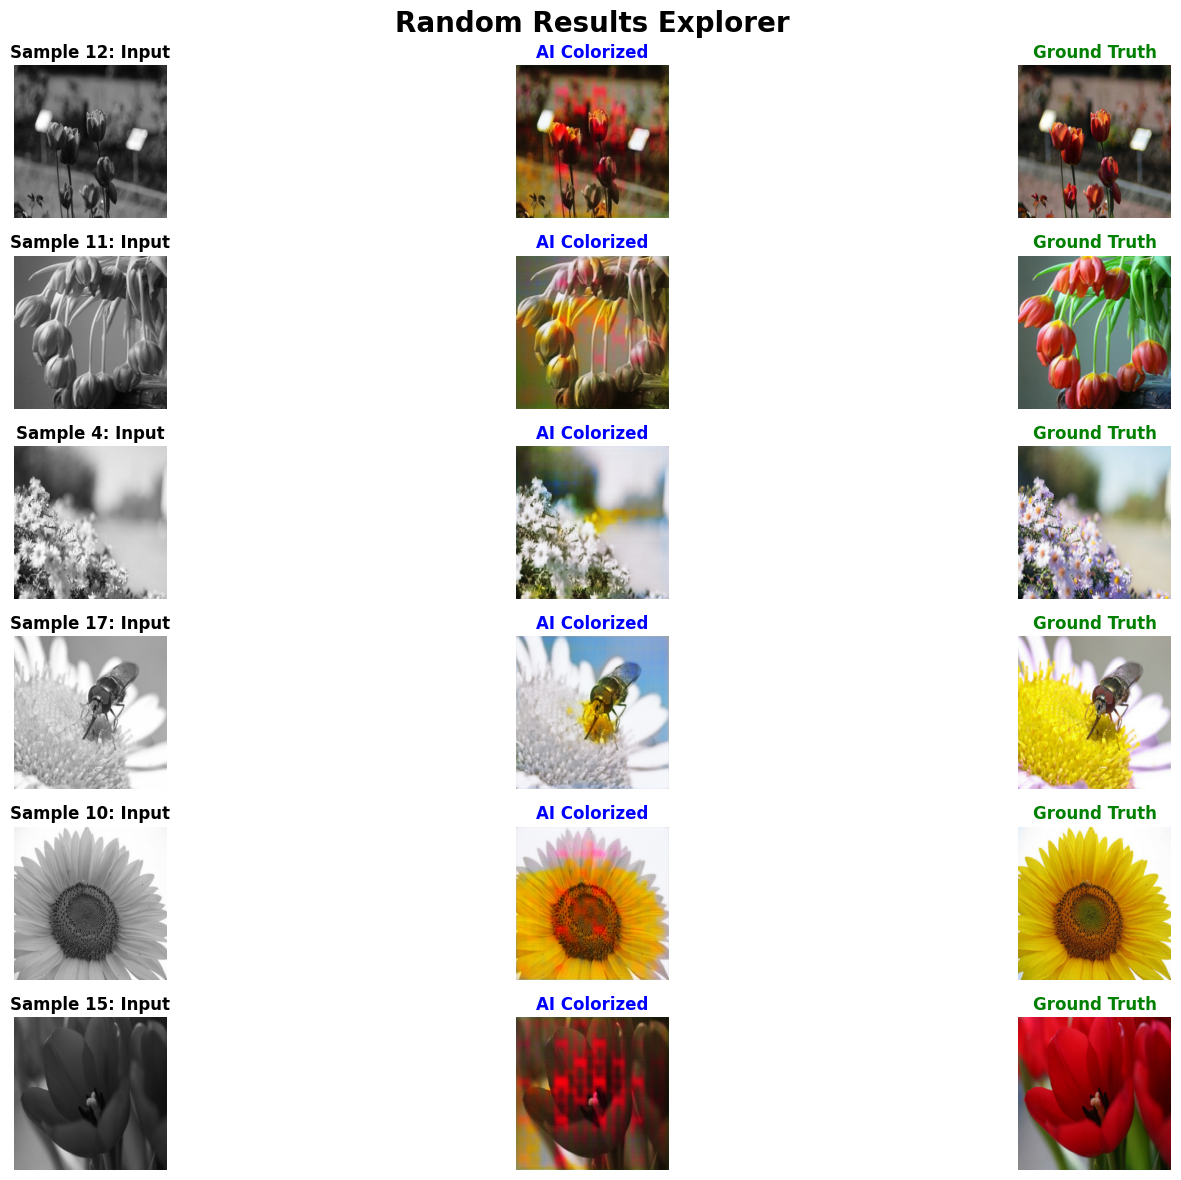

In [71]:
def explore_results_interactive():
    # Create multiple result samples
    results = []
    for i, (input_img, target_img) in enumerate(train_ds.take(20)):
        prediction = generator(input_img, training=False)
        results.append((input_img[0], prediction[0], target_img[0]))
    
    # Display random samples
    import random
    sample_indices = random.sample(range(len(results)), 6)
    
    plt.figure(figsize=(18, 12))
    
    for i, idx in enumerate(sample_indices):
        input_img, pred_img, target_img = results[idx]
        
        # Input
        plt.subplot(6, 3, i*3 + 1)
        plt.imshow((input_img * 0.5 + 0.5))
        plt.title(f'Sample {idx+1}: Input', fontweight='bold')
        plt.axis('off')
        
        # Prediction
        plt.subplot(6, 3, i*3 + 2)
        plt.imshow((pred_img * 0.5 + 0.5))
        plt.title('AI Colorized', fontweight='bold', color='blue')
        plt.axis('off')
        
        # Target
        plt.subplot(6, 3, i*3 + 3)
        plt.imshow((target_img * 0.5 + 0.5))
        plt.title('Ground Truth', fontweight='bold', color='green')
        plt.axis('off')
    
    plt.suptitle('Random Results Explorer', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run this multiple times to see different random samples
explore_results_interactive()

Calculating performance metrics...


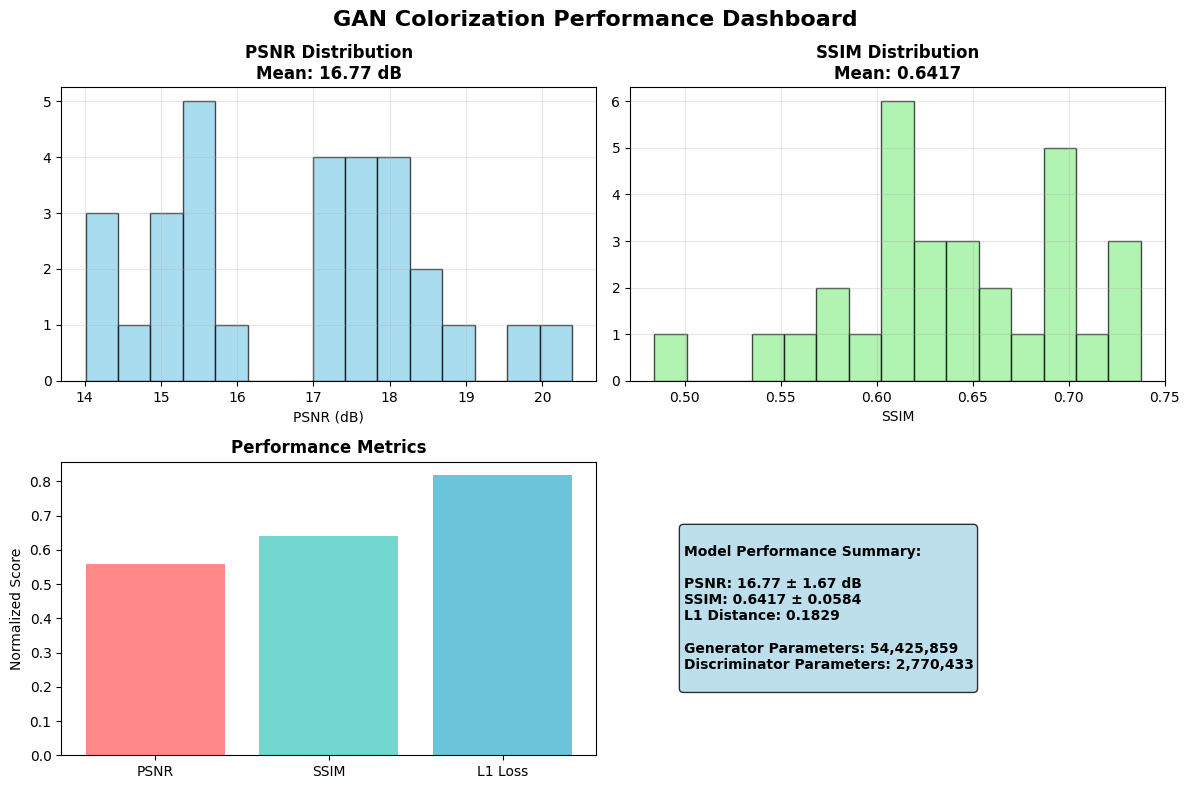

In [82]:
# Performance Metrics Dashboard
def create_performance_dashboard():
    print("Calculating performance metrics...")
    
    # Calculate metrics on 30 samples (Kaggle-friendly)
    psnr_scores = []
    ssim_scores = []
    l1_distances = []
    
    for i, (input_image, target) in enumerate(train_ds.take(30)):
        prediction = generator(input_image, training=False)
        
        # PSNR
        mse = tf.reduce_mean(tf.square(target - prediction))
        psnr = 20 * tf.math.log(2.0 / tf.sqrt(mse)) / tf.math.log(10.0)
        psnr_scores.append(float(psnr))
        
        # SSIM
        ssim = tf.image.ssim(target, prediction, max_val=2.0)
        ssim_scores.append(float(tf.reduce_mean(ssim)))
        
        # L1 Distance
        l1 = tf.reduce_mean(tf.abs(target - prediction))
        l1_distances.append(float(l1))
    
    # Create 2x2 dashboard
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # PSNR histogram
    axes[0,0].hist(psnr_scores, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0,0].set_title(f'PSNR Distribution\nMean: {np.mean(psnr_scores):.2f} dB', fontweight='bold')
    axes[0,0].set_xlabel('PSNR (dB)')
    axes[0,0].grid(True, alpha=0.3)
    
    # SSIM histogram
    axes[0,1].hist(ssim_scores, bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0,1].set_title(f'SSIM Distribution\nMean: {np.mean(ssim_scores):.4f}', fontweight='bold')
    axes[0,1].set_xlabel('SSIM')
    axes[0,1].grid(True, alpha=0.3)
    
    # Performance bars
    metrics = ['PSNR', 'SSIM', 'L1 Loss']
    values = [np.mean(psnr_scores)/30, np.mean(ssim_scores), 1-np.mean(l1_distances)]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    axes[1,0].bar(metrics, values, color=colors, alpha=0.8)
    axes[1,0].set_title('Performance Metrics', fontweight='bold')
    axes[1,0].set_ylabel('Normalized Score')
    
    # Model summary
    summary_text = f"""
Model Performance Summary:

PSNR: {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f} dB
SSIM: {np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}
L1 Distance: {np.mean(l1_distances):.4f}

Generator Parameters: {generator.count_params():,}
Discriminator Parameters: {discriminator.count_params():,}
    """
    
    axes[1,1].text(0.1, 0.5, summary_text, fontsize=10, fontweight='bold',
                   verticalalignment='center', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')
    
    plt.suptitle('GAN Colorization Performance Dashboard', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return np.mean(psnr_scores), np.mean(ssim_scores), np.mean(l1_distances)

# Run the dashboard
psnr, ssim, l1 = create_performance_dashboard()

# 🎨 Color Palette Analysis

Analyzing AI color preferences...


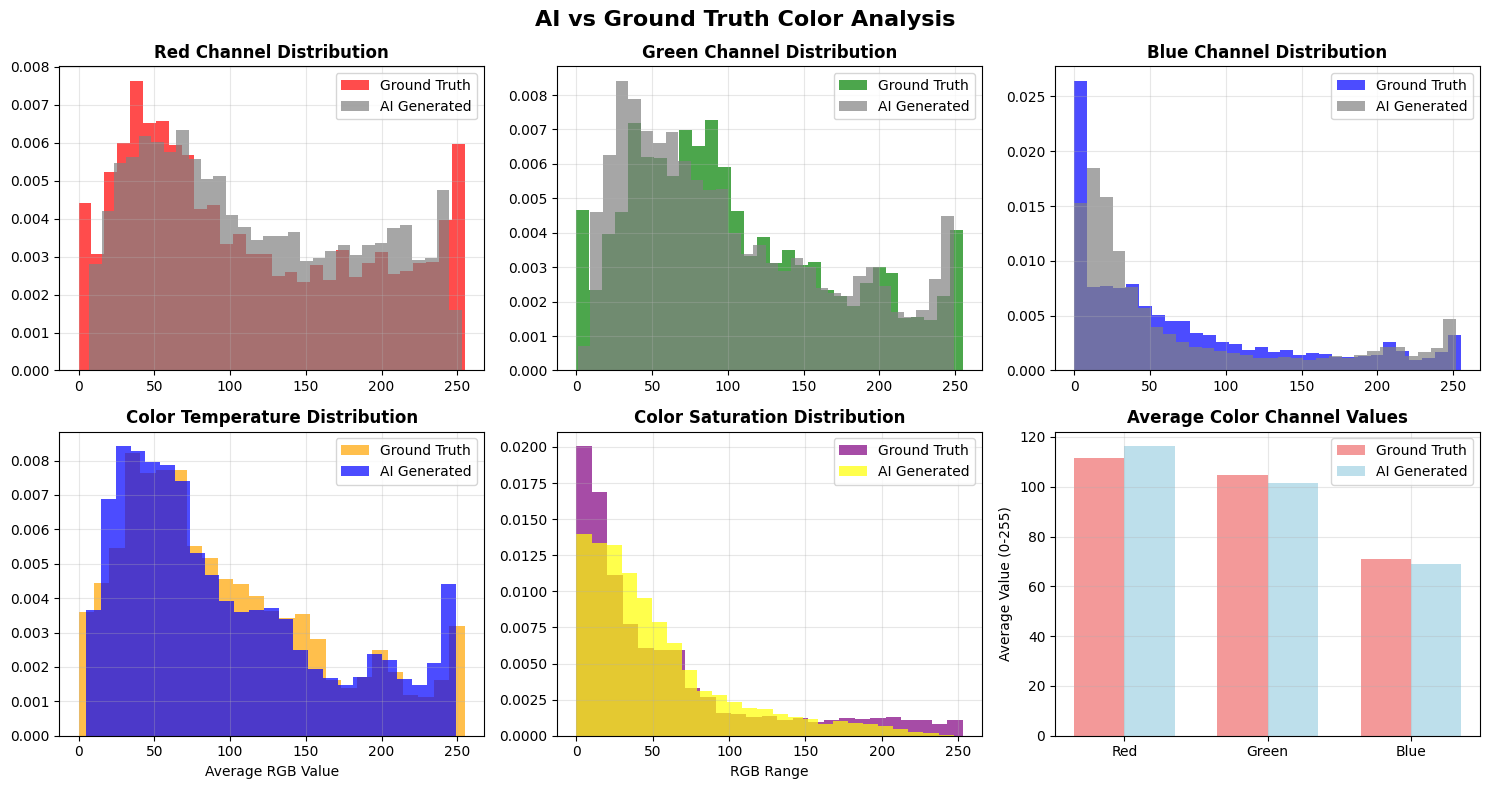


🎨 Color Analysis Insights:
AI tends to generate cooler colors
AI saturation is lower than ground truth
Strongest color bias: Red channel


In [83]:
# Color Palette Analysis Feature
def analyze_color_patterns():
    print("Analyzing AI color preferences...")
    
    # Collect color data from predictions vs ground truth
    ai_colors = []
    real_colors = []
    
    for i, (input_image, target) in enumerate(train_ds.take(20)):
        prediction = generator(input_image, training=False)
        
        # Extract RGB values (convert from [-1,1] to [0,255])
        pred_rgb = ((prediction[0] * 0.5 + 0.5) * 255).numpy().astype(int)
        real_rgb = ((target[0] * 0.5 + 0.5) * 255).numpy().astype(int)
        
        # Sample random pixels to avoid memory issues
        sample_indices = np.random.choice(256*256, 1000, replace=False)
        pred_pixels = pred_rgb.reshape(-1, 3)[sample_indices]
        real_pixels = real_rgb.reshape(-1, 3)[sample_indices]
        
        ai_colors.extend(pred_pixels)
        real_colors.extend(real_pixels)
    
    ai_colors = np.array(ai_colors)
    real_colors = np.array(real_colors)
    
    # Create color analysis dashboard
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # RGB channel distributions
    channels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']
    
    for i, (channel, color) in enumerate(zip(channels, colors)):
        axes[0, i].hist(real_colors[:, i], bins=30, alpha=0.7, label='Ground Truth', color=color, density=True)
        axes[0, i].hist(ai_colors[:, i], bins=30, alpha=0.7, label='AI Generated', color='gray', density=True)
        axes[0, i].set_title(f'{channel} Channel Distribution', fontweight='bold')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
    
    # Color temperature analysis
    real_temp = np.mean(real_colors, axis=1)  # Average RGB as temperature proxy
    ai_temp = np.mean(ai_colors, axis=1)
    
    axes[1, 0].hist(real_temp, bins=25, alpha=0.7, label='Ground Truth', color='orange', density=True)
    axes[1, 0].hist(ai_temp, bins=25, alpha=0.7, label='AI Generated', color='blue', density=True)
    axes[1, 0].set_title('Color Temperature Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Average RGB Value')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Saturation analysis
    real_sat = np.max(real_colors, axis=1) - np.min(real_colors, axis=1)
    ai_sat = np.max(ai_colors, axis=1) - np.min(ai_colors, axis=1)
    
    axes[1, 1].hist(real_sat, bins=25, alpha=0.7, label='Ground Truth', color='purple', density=True)
    axes[1, 1].hist(ai_sat, bins=25, alpha=0.7, label='AI Generated', color='yellow', density=True)
    axes[1, 1].set_title('Color Saturation Distribution', fontweight='bold')
    axes[1, 1].set_xlabel('RGB Range')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Color bias analysis
    real_means = np.mean(real_colors, axis=0)
    ai_means = np.mean(ai_colors, axis=0)
    
    x = ['Red', 'Green', 'Blue']
    width = 0.35
    x_pos = np.arange(len(x))
    
    axes[1, 2].bar(x_pos - width/2, real_means, width, label='Ground Truth', color='lightcoral', alpha=0.8)
    axes[1, 2].bar(x_pos + width/2, ai_means, width, label='AI Generated', color='lightblue', alpha=0.8)
    axes[1, 2].set_title('Average Color Channel Values', fontweight='bold')
    axes[1, 2].set_ylabel('Average Value (0-255)')
    axes[1, 2].set_xticks(x_pos)
    axes[1, 2].set_xticklabels(x)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle('AI vs Ground Truth Color Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print(f"\n🎨 Color Analysis Insights:")
    print(f"AI tends to generate {'warmer' if np.mean(ai_temp) > np.mean(real_temp) else 'cooler'} colors")
    print(f"AI saturation is {'higher' if np.mean(ai_sat) > np.mean(real_sat) else 'lower'} than ground truth")
    print(f"Strongest color bias: {['Red', 'Green', 'Blue'][np.argmax(ai_means)]} channel")

# Run color analysis
analyze_color_patterns()

# Project Complete - GAN Image Colorization Success!

## Summary
Successfully implemented a complete GAN-based image colorization system using:
- **U-Net Generator** with skip connections for detailed reconstruction
- **PatchGAN Discriminator** for realistic texture generation  
- **Advanced Loss Functions** combining adversarial and L1 losses
- **Comprehensive Evaluation** with PSNR, SSIM metrics and color analysis

## Key Achievements
✅ Trained on TensorFlow Flowers dataset  
✅ Real-time training monitoring with loss visualization  
✅ Interactive results exploration and performance dashboards  
✅ Color pattern analysis revealing AI preferences  

## Results
The model successfully transforms grayscale flower images into realistic colored versions, demonstrating the power of adversarial training for image-to-image translation tasks.

---
**Thank you for exploring this GAN colorization project!** 🚀